In [2]:
from __future__ import print_function
from __future__ import division

import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)
    
from utils.plots import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from  kernelfuzzy.fuzzyset import FuzzySet
from kernelfuzzy.fuzzysystem import get_rule_antecedents,plot_membership_fun
from  kernelfuzzy.fuzzification import FuzzyData, NonSingletonFuzzifier
from kernelfuzzy.kernels import gram_matrix_KBF_kernel,KBFkernel,NonSingletonKernel
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from kernelfuzzy.kernels import nonsingleton_gaussian_kernel, gram_matrix_nonsingleton_gaussian_kernel
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz # for FCM
import pickle

This notebook compares a data-driven  construction of Membership functions (MFs) by 1) Linguistic Modified Fuzzy C-Means clustering (LMFCM) vs 2) regularized kernel machines
* LMFCM paper: Fuzzy Set Qualitative Comparative Analysis(fsQCA): Challenges and Applications

##  Dataset


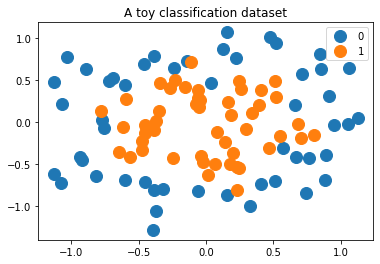

In [3]:
# we create 40 separable points
#X, y = make_blobs(n_samples=100, centers=2, random_state=6)
#X_test, y_test = make_blobs(n_samples=100, centers=2, random_state=6)
#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
#X_test, y_test = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)

#X, y = make_moons(noise=0.3, random_state=0)
#X_test, y_test = make_moons(noise=0.3, random_state=0)

X, y = make_circles(noise=0.2, factor=0.5, random_state=1)
X_test, y_test = make_circles(noise=0.2, factor=0.5, random_state=1)


df=pd.DataFrame(data=X,columns=['x1','x2'])
df['y']=y
#plot the dataset
groups = df.groupby('y')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x1, group.x2, marker='o', linestyle='', ms=12, label=name)
ax.legend()
plt.title("A toy classification dataset")
plt.show()

## Membership functions from  LMFCM

Colunm Name :  x1


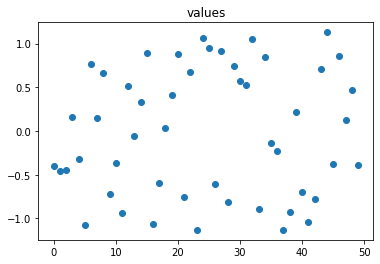

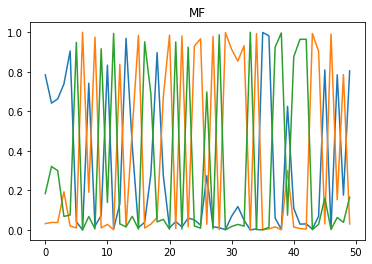

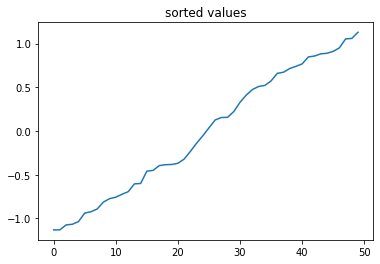

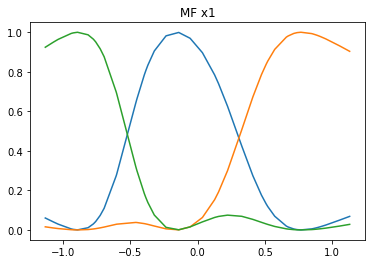

Colunm Name :  x2


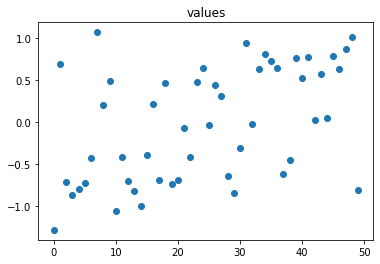

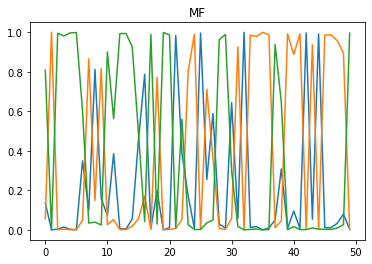

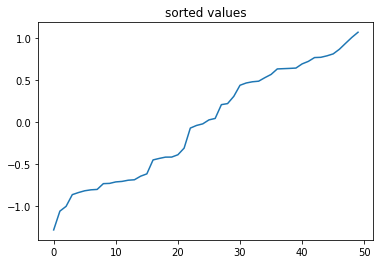

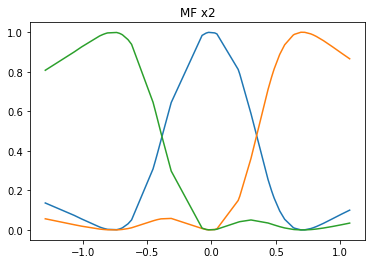

Colunm Name :  x1


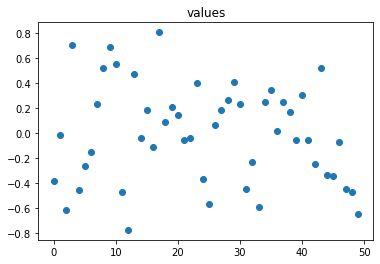

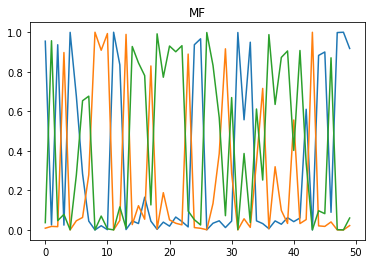

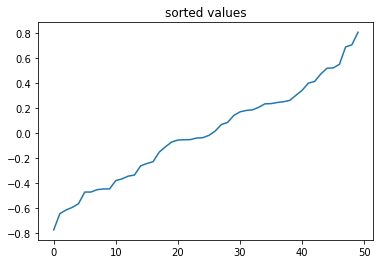

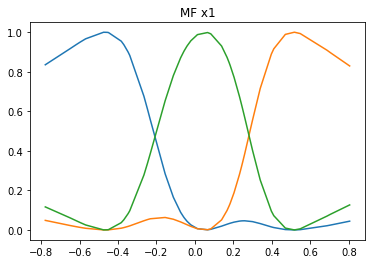

Colunm Name :  x2


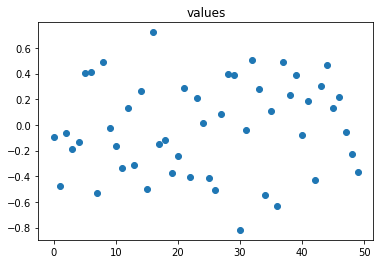

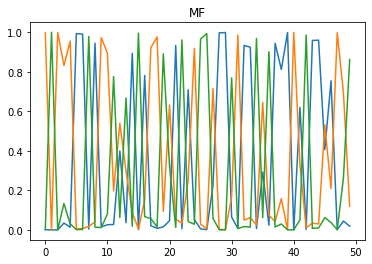

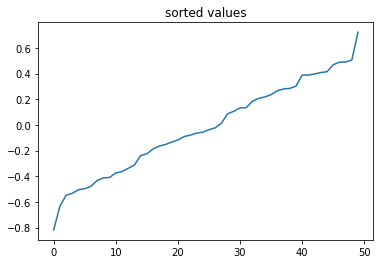

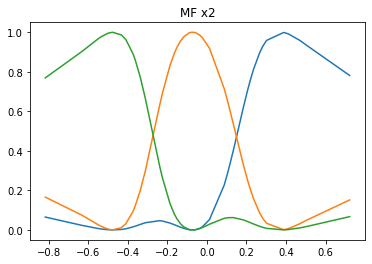

In [4]:
#cluster each variable independently per category
#class 0
colnames=['x1','x2']
n_centers_per_column=[3,3]
plot_mf_FCM(df.loc[df['y']==0], colnames, n_centers_per_column)

#class 1
plot_mf_FCM(df.loc[df['y']==1], colnames, n_centers_per_column)


## Membership functions from SVM with nonsingleton kernel on fuzzy sets

In [5]:
  
pipe = Pipeline([
    ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
    ('NSKernel', NonSingletonKernel()),
    ('svm', NuSVC())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('Fuzzifier__std_proportion',np.arange(0.01,np.std(X),0.1)),
    ('NSKernel__param', 2.0**np.arange(-20,20)),
    ('svm__kernel', ['precomputed']),
    ('svm__nu', np.arange(0.05,0.2,0.05)),
    #('svm__C', 2.0**np.arange(-5,20))
])

#model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model_SVM_NS = RandomizedSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1,n_iter=100)
model_SVM_NS.fit(X, y)
    
print('Model parameters : {}'.format(model_SVM_NS.best_params_))
print('support vectors: {}'.format( model_SVM_NS.best_estimator_['svm'].support_))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.0s


Model parameters : {'svm__nu': 0.1, 'svm__kernel': 'precomputed', 'NSKernel__param': 0.0078125, 'Fuzzifier__std_proportion': 0.21000000000000002}
support vectors: [ 5  6 11 15 20 43 48 56 64 86  3  4 18 30 44 57 69 97]


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.3s finished


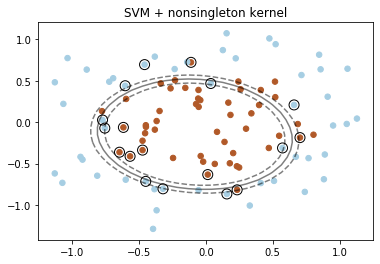

/Users/jorgegd/Documents/GITProjects/fuzzy-kernel-machines/utils/plots.py:205: UserWarning:

No contour levels were found within the data range.



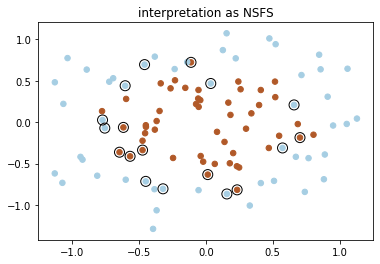

[ 5  6 11 15 20 43 48]
[ 3  4 18 30 44 56 57 64 69 86 97]
Membership function Rule antecedents class 0


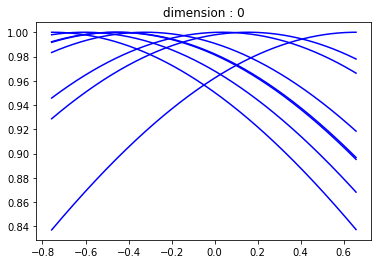

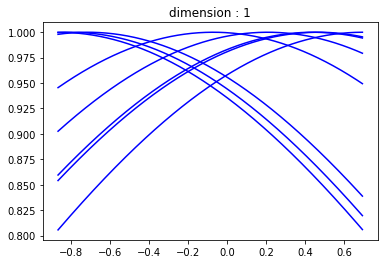

Membership function of fuzzy numbers linked to rule antecedents


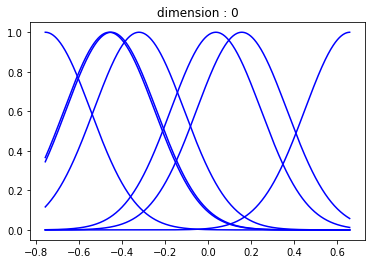

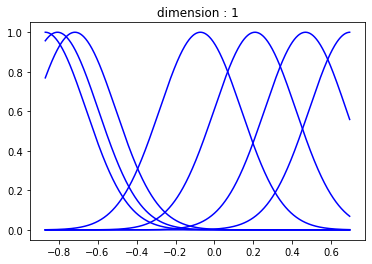

plot of vectors of fuzzy sets linked to rule antecedents


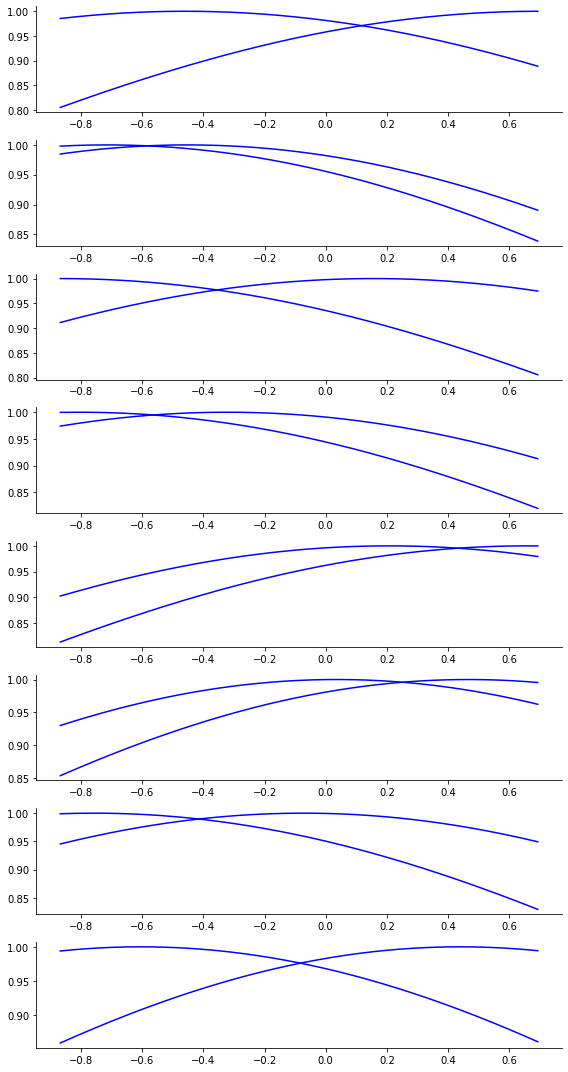

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


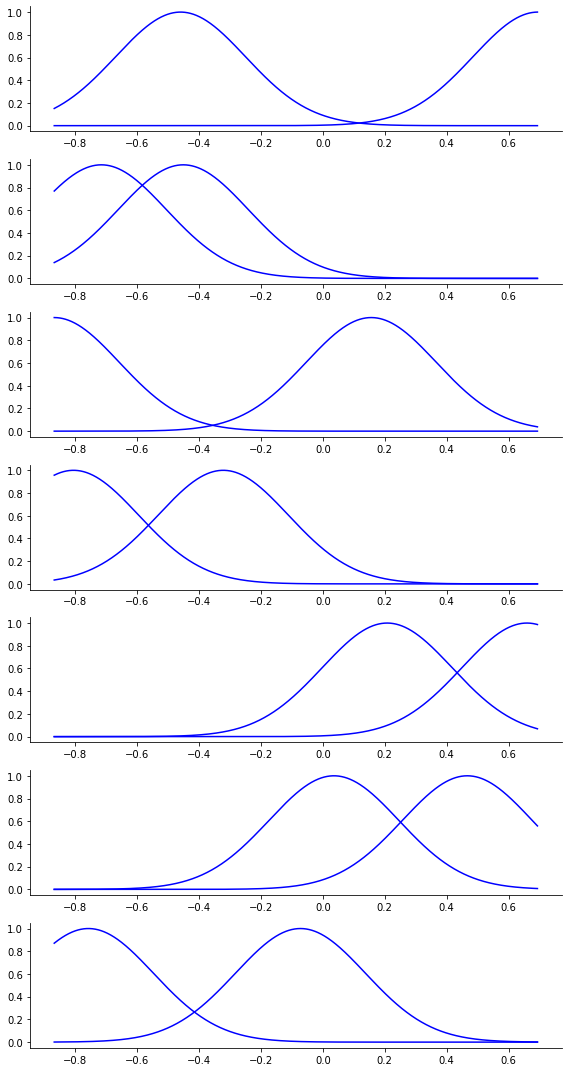

Membership function Rule antecedents class 1


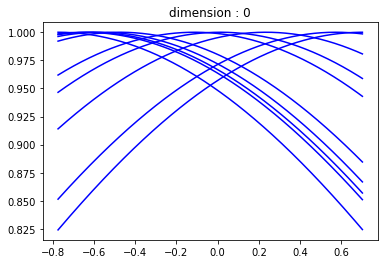

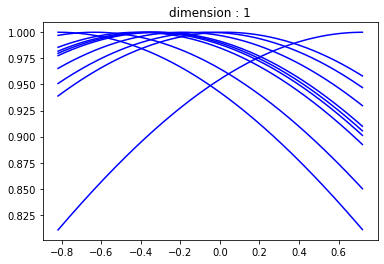

Membership function of fuzzy numbers linked to rule antecedents


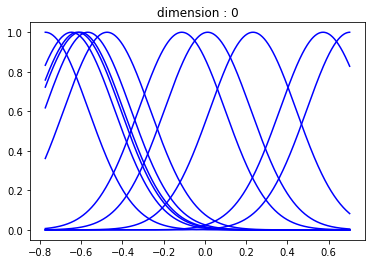

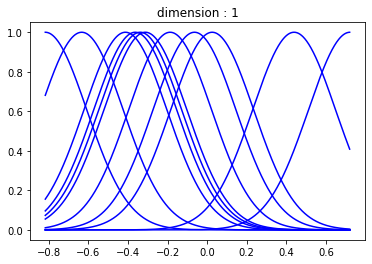

plot of vectors of fuzzy sets linked to rule antecedents


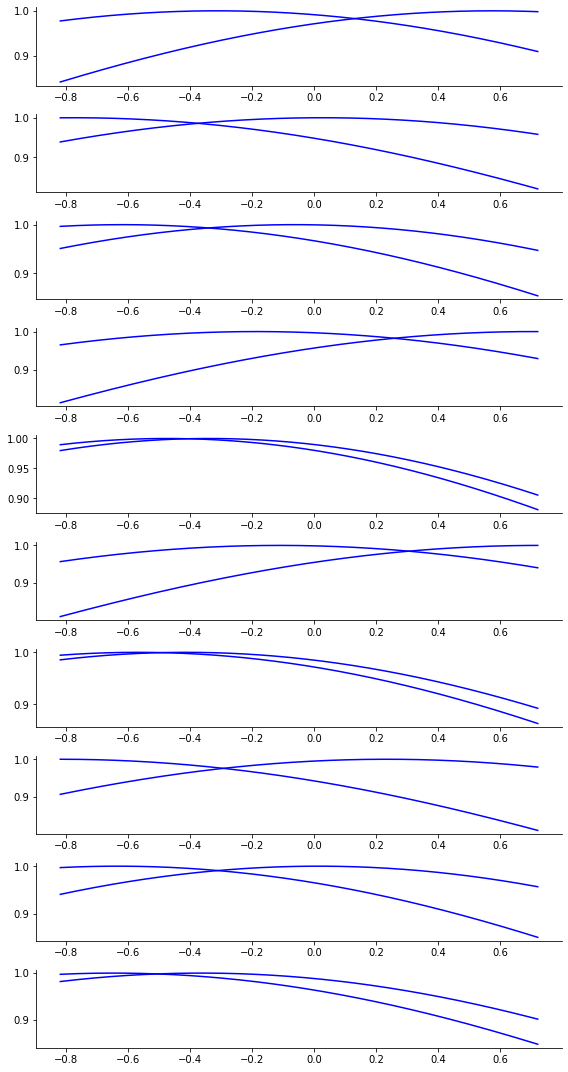

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


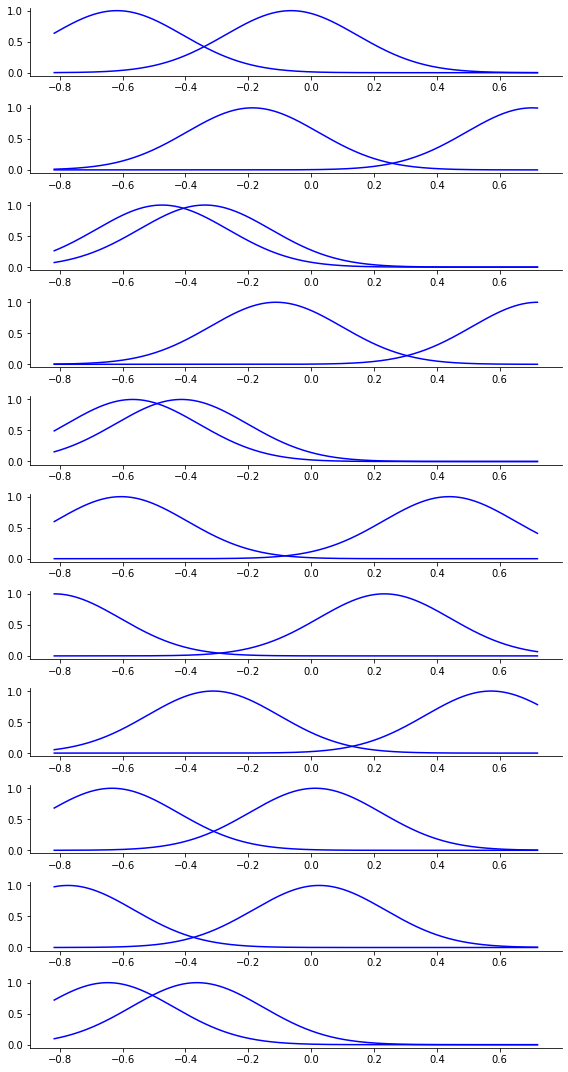

In [7]:
#rule generation
percentage_x_plot=0
gamma=model_SVM_NS.best_params_['NSKernel__param']
std_proportion=model_SVM_NS.best_params_['Fuzzifier__std_proportion']
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)

plt.title("SVM + nonsingleton kernel")
plot_decision_function_kernel_Nonsingleton(X,  y, model_SVM_NS.best_estimator_['svm'], std_proportion,gamma, type=0)

plt.title("interpretation as NSFS")
plot_decision_function_kernel_KBF(X,  y, model_SVM_NS.best_estimator_['svm'], std_proportion,gamma, type=0)

rules_antecedents=get_rule_antecedents(model_SVM_NS.best_estimator_['svm'], fuzzy_data, gamma)

index_sv_class_0=model_SVM_NS.best_estimator_['svm'].support_[0:model_SVM_NS.best_estimator_['svm'].n_support_[1]-1]
print(index_sv_class_0)
index_sv_class_1=np.setdiff1d(model_SVM_NS.best_estimator_['svm'].support_,index_sv_class_0)
print(index_sv_class_1)

rules_antecedents_class_0=rules_antecedents[0:model_SVM_NS.best_estimator_['svm'].n_support_[1],:]
rules_antecedents_class_1=rules_antecedents[model_SVM_NS.best_estimator_['svm'].n_support_[1]::,:]


#class0
print("Membership function Rule antecedents class 0")

plot_membership_fun(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)

#class1

print("Membership function Rule antecedents class 1")

plot_membership_fun(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)


Colunm Name :  x1


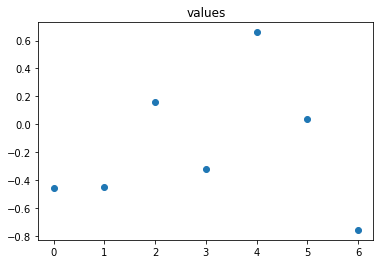

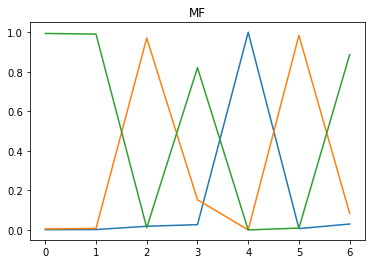

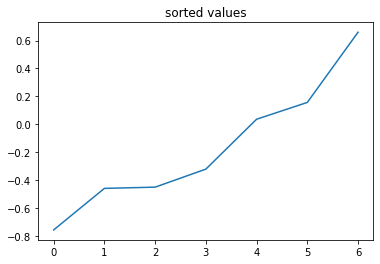

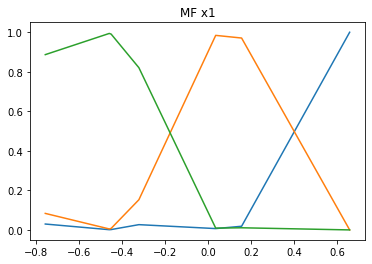

Colunm Name :  x2


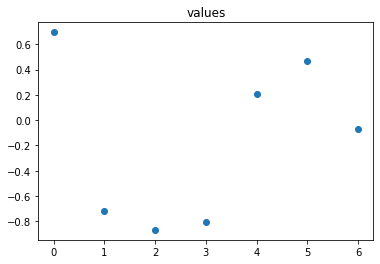

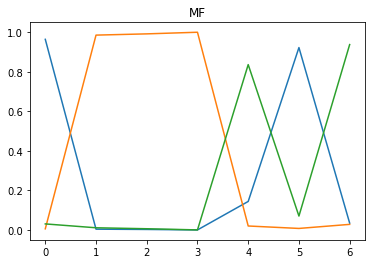

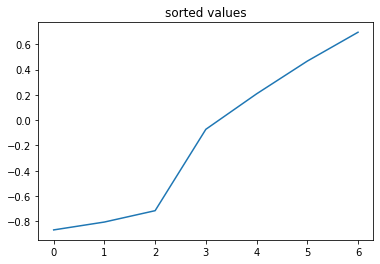

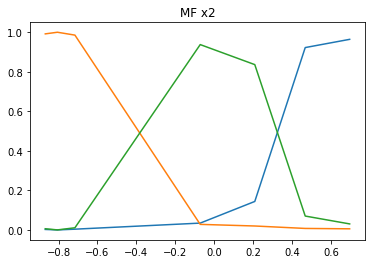

Colunm Name :  x1


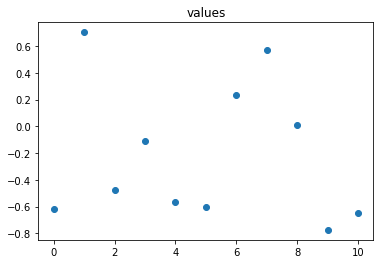

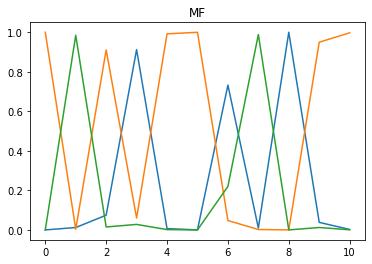

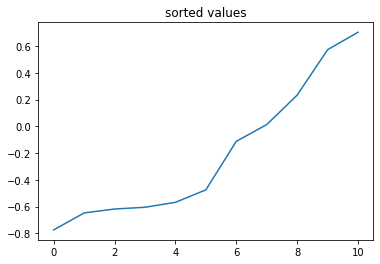

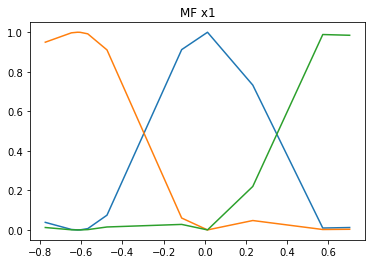

Colunm Name :  x2


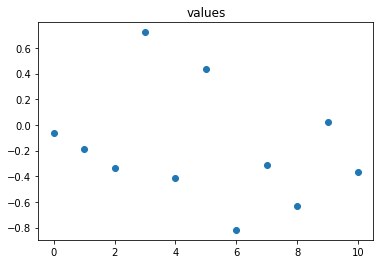

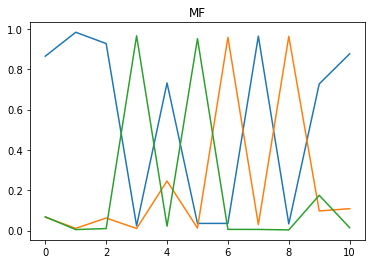

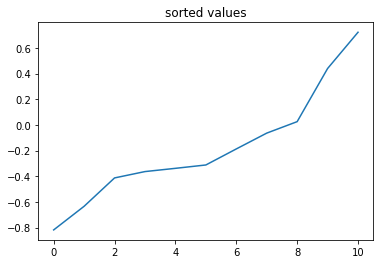

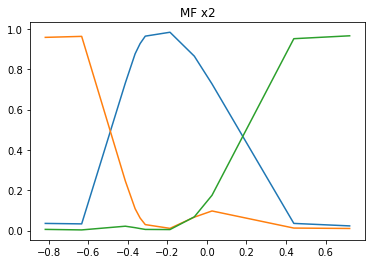

In [8]:
#clustering the fuzzy numbers
colnames=['x1','x2']
n_centers_per_column=[3,3]
plot_mf_FCM(df.iloc[index_sv_class_0], colnames, n_centers_per_column)
plot_mf_FCM(df.iloc[index_sv_class_1], colnames, n_centers_per_column)


In [9]:
# using KBF kernel
pipe = Pipeline([
    ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
    ('Kernel', KBFkernel()),
    ('svm', NuSVC())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('Fuzzifier__std_proportion',np.arange(0.01,np.std(X),0.1)),
    ('Kernel__param', 2.0**np.arange(-20,-1)),
    ('svm__kernel', ['precomputed']),
    ('svm__nu', np.arange(0.1,0.3,0.1)),
])


#model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model_SVM_KBF = RandomizedSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1,n_iter=100)
model_SVM_KBF.fit(X, y)

print('Model parameters : {}'.format(model_SVM_KBF.best_params_))
print('support vectors: {}'.format( model_SVM_KBF.best_estimator_['svm'].support_))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   28.9s


Model parameters : {'svm__nu': 0.1, 'svm__kernel': 'precomputed', 'Kernel__param': 0.015625, 'Fuzzifier__std_proportion': 0.01}
support vectors: [ 2  5  6 11 15 16 17 19 20 24 25 27 29 35 36 38 39 43 45 46 48 52 53 55
 56 58 60 63 64 66 71 74 76 79 80 81 82 83 84 86 87 90 91 94 96 98 99  0
  1  3  4  7 10 12 13 14 18 21 22 26 30 31 32 33 34 40 41 42 44 47 49 51
 57 61 62 67 69 70 72 73 75 77 78 85 88 89 95 97]


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.0s finished


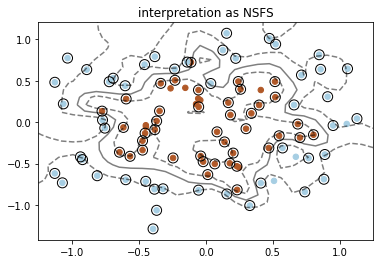

[ 2  5  6 11 15 16 17 19 20 24 25 27 29 35 36 38 39 43 45 46 48 52 53 55
 56 58 60 63 64 66 71 74 76 79 80 81 82 83 84 86]
[ 0  1  3  4  7 10 12 13 14 18 21 22 26 30 31 32 33 34 40 41 42 44 47 49
 51 57 61 62 67 69 70 72 73 75 77 78 85 87 88 89 90 91 94 95 96 97 98 99]
Membership function Rule antecedents class 0


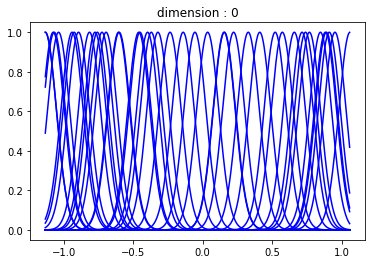

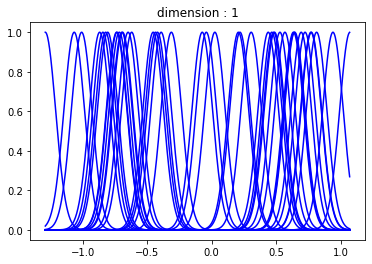

Membership function of fuzzy numbers linked to rule antecedents


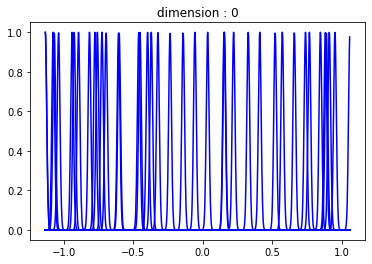

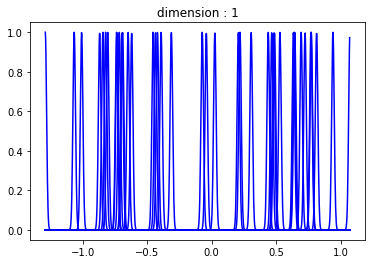

plot of vectors of fuzzy sets linked to rule antecedents


/Users/jorgegd/Documents/GITProjects/fuzzy-kernel-machines/utils/plots.py:168: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



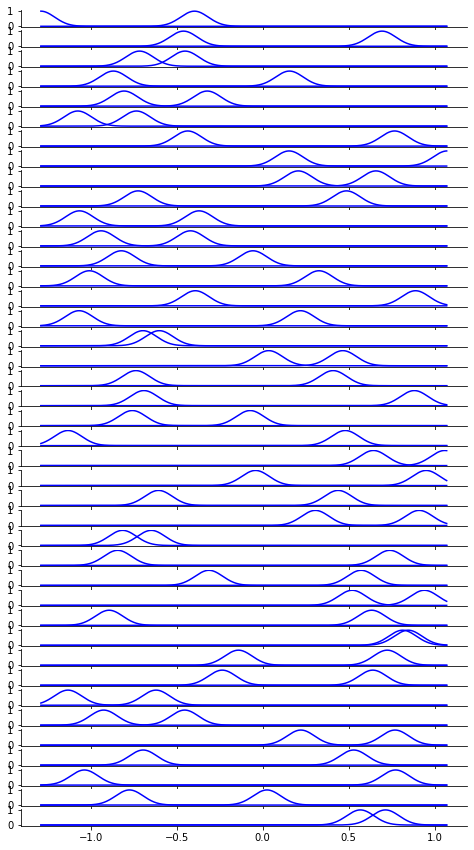

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


/Users/jorgegd/Documents/GITProjects/fuzzy-kernel-machines/utils/plots.py:168: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



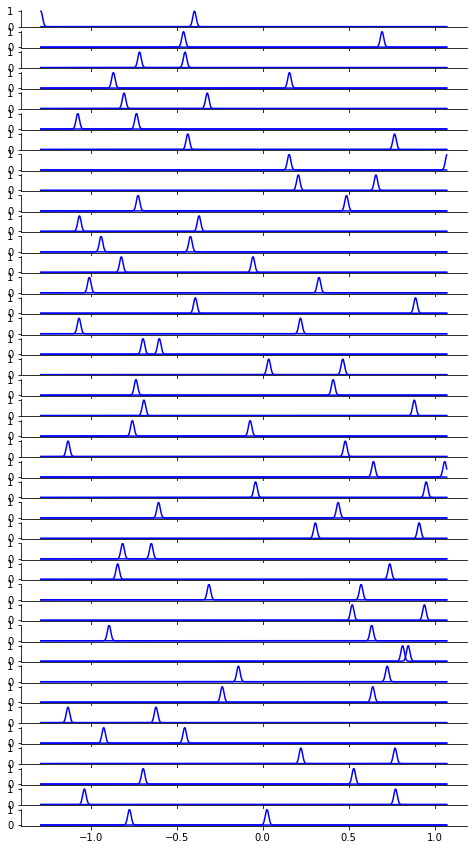

Membership function Rule antecedents class 1


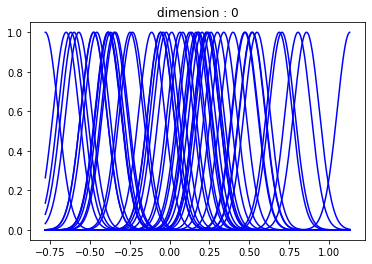

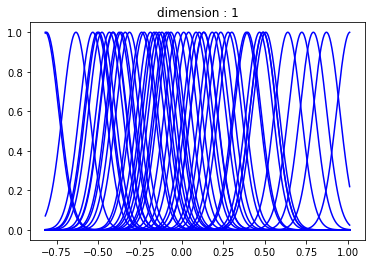

Membership function of fuzzy numbers linked to rule antecedents


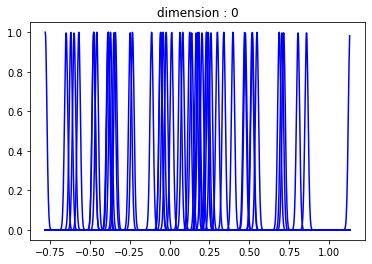

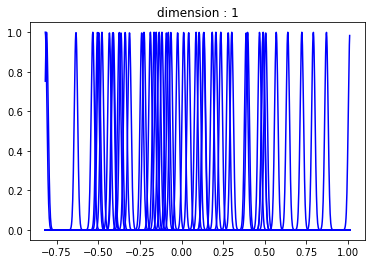

plot of vectors of fuzzy sets linked to rule antecedents


/Users/jorgegd/Documents/GITProjects/fuzzy-kernel-machines/utils/plots.py:168: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



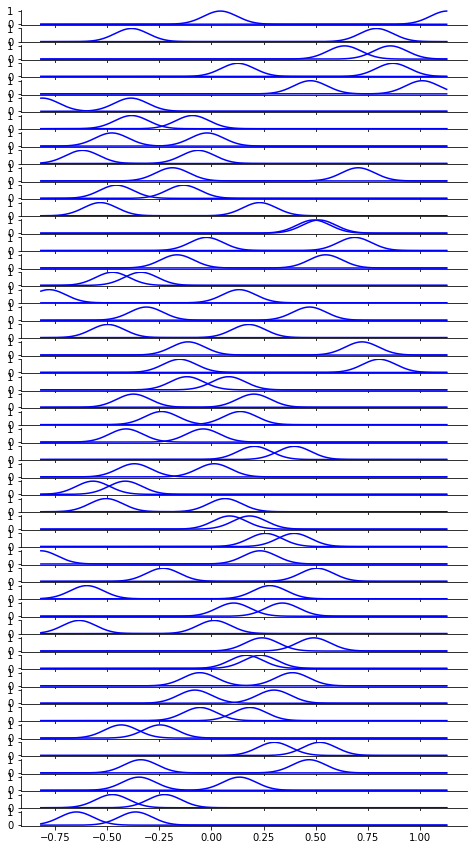

plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents


/Users/jorgegd/Documents/GITProjects/fuzzy-kernel-machines/utils/plots.py:168: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



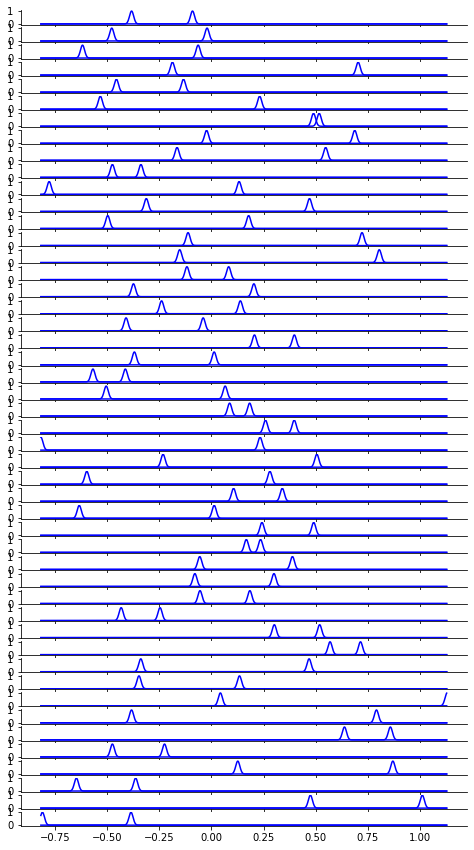

In [10]:
percentage_x_plot=0
gamma=model_SVM_KBF.best_params_['Kernel__param']
std_proportion=model_SVM_KBF.best_params_['Fuzzifier__std_proportion']
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)

plt.title("interpretation as NSFS")
plot_decision_function_kernel_KBF(X,  y, model_SVM_KBF.best_estimator_['svm'], std_proportion,gamma, type=0)

rules_antecedents=get_rule_antecedents(model_SVM_KBF.best_estimator_['svm'], fuzzy_data, gamma)

###
index_sv_class_0=model_SVM_KBF.best_estimator_['svm'].support_[0:model_SVM_KBF.best_estimator_['svm'].n_support_[1]-1]
print(index_sv_class_0)
index_sv_class_1=np.setdiff1d(model_SVM_KBF.best_estimator_['svm'].support_,index_sv_class_0)
print(index_sv_class_1)

rules_antecedents_class_0=rules_antecedents[0:model_SVM_KBF.best_estimator_['svm'].n_support_[1],:]
rules_antecedents_class_1=rules_antecedents[model_SVM_KBF.best_estimator_['svm'].n_support_[1]::,:]

#class0
print("Membership function Rule antecedents class 0")

plot_membership_fun(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)

#class1

print("Membership function Rule antecedents class 1")

plot_membership_fun(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)

###


Colunm Name :  x1


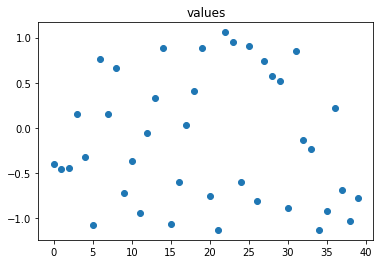

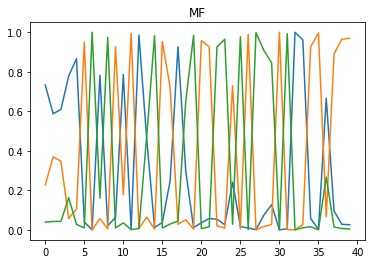

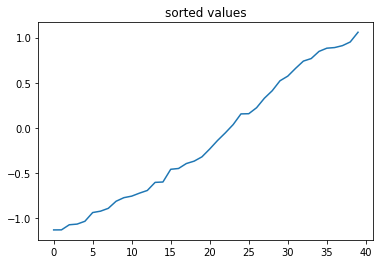

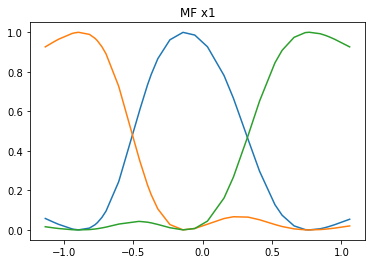

Colunm Name :  x2


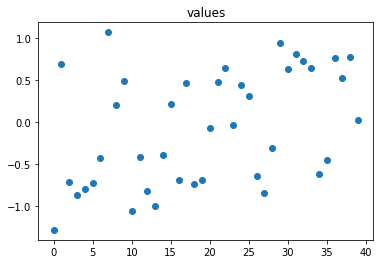

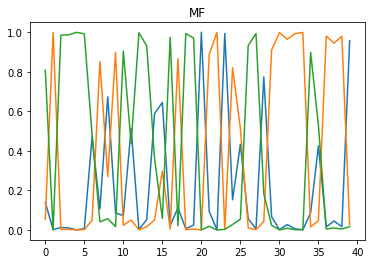

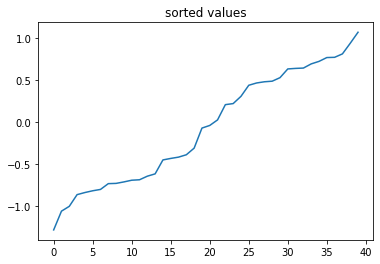

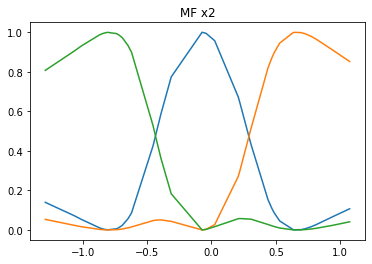

Colunm Name :  x1


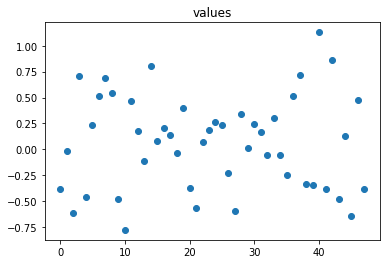

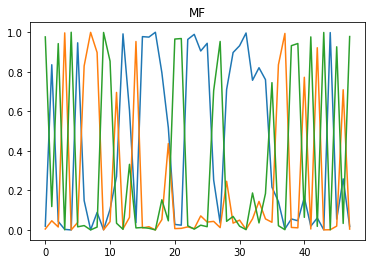

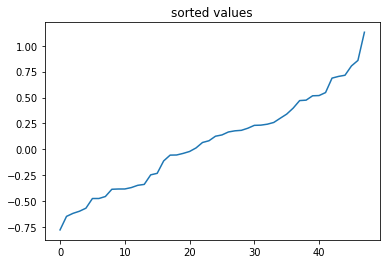

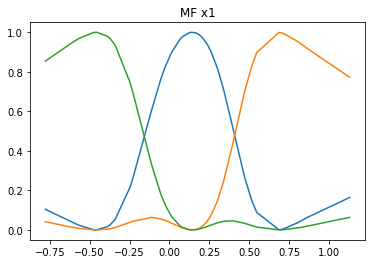

Colunm Name :  x2


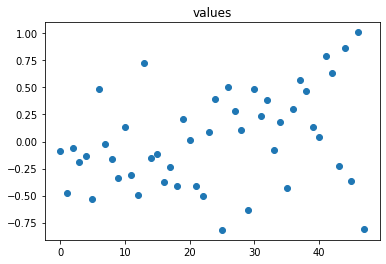

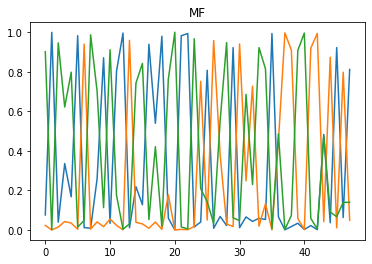

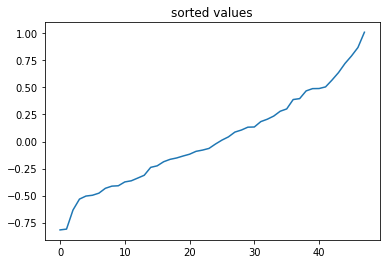

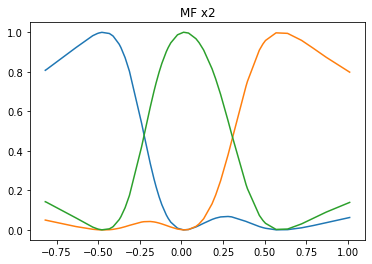

In [11]:
#clustering the fuzzy numbers
colnames=['x1','x2']
n_centers_per_column=[3,3]

plot_mf_FCM(df.iloc[index_sv_class_0], colnames, n_centers_per_column)
plot_mf_FCM(df.iloc[index_sv_class_1], colnames, n_centers_per_column)
